# Bidirectional RNN for sentiment classification

Here IMBD movie review classification is used

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

import collections
import re
import random
import os
import requests
import zipfile
import tarfile
import hashlib
import time

np.random.seed(seed=1)
torch.manual_seed(1)
!mkdir figures # for saving plots

mkdir: figures: File exists


# Data Preparation

## Standard Download Utils 

In [6]:
# Required functions for downloading data


def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

## Download executor

uncomment when want to download
```
# data_dir = download_extract("aclImdb", "aclImdb")
```

In [7]:
DATA_HUB = dict()
DATA_HUB["aclImdb"] = (
    "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    "01ada507287d82875905620988597833ad4e0903",
)

data_dir = download_extract("aclImdb", "aclImdb")

## Download to Data converter

Here we send the input data in-memory and convert provide labels based on positive and negative reviews

In [8]:
def read_imdb(data_dir, is_train, max_reviews):
    data, labels, paths = [], [], { "pos": [], "neg": [] }
    classification = ["pos", "neg"]
    for label in classification:
        folder_name = os.path.join(data_dir, "train" if is_train else "test", label)
        for file in os.listdir(folder_name):
            paths[label].append(os.path.join(folder_name, file))
    while len(data) < max_reviews:
        label = classification[random.randrange(2)]
        index = random.randrange(len(paths[label]))
        with open(paths[label][index], "rb") as f:
            review = f.read().decode("utf-8").replace("\n", "")
            data.append(review)
            labels.append(1 if label == "pos" else 0)
    return data, labels


train_data = read_imdb(data_dir, is_train=True, max_reviews=100)
print("# trainings:", len(train_data[0]))
for x, y in zip(train_data[0][:100], train_data[1][:100]):
    print("label:", y, "review:", x[0:60])

# trainings: 100
label: 0 review: A low point in human interaction was reached by the Maysles 
label: 0 review: Though the title may suggest examples of the 10 commandments
label: 1 review: The idea of making a film about the Beatles sounds doomed id
label: 0 review: In a movie that follows a struggling actor, played, evidentl
label: 0 review: his costume drama is ill cast and without charm.<br /><br />
label: 0 review: As a youth pastor I heard good things about this movie. Then
label: 0 review: 1st watched 12/6/2009 - 4 out of 10 (Dir-Walter Lang): Disap
label: 0 review: I find myself wondering what the people who gave this a 10 s
label: 0 review: Well the previews looked funny and I usually don't go to mov
label: 0 review: Someone must have been seriously joking when they made this 
label: 1 review: After a love triangle story in Har Dil Jo Pyaar Karega these
label: 1 review: Again, it seems totally illogical, to me at least, that "Art
label: 0 review: Granting the budget and time c

In [9]:
def tokenize(lines, token="word"):
    """Split text lines into word or character tokens."""
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("ERROR: unknown token type: " + token)


class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    display.set_matplotlib_formats("svg")
    plt.rcParams["figure.figsize"] = figsize

# Analysis
#### Train tokens
```
[['For', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', ....]]
```
format : 
```
[ [~line1~], [~line2~], [~line3~]....]
```


In [10]:
train_tokens = tokenize(train_data[0], token="word")
# print('train_tokens',train_tokens[:2])
vocab = Vocab(train_tokens, min_freq=5, reserved_tokens=["<pad>"])
print(vocab[train_tokens[1]])
print(vocab.to_tokens([1,10,31,22]))
print(vocab.token_freqs[:10])
print(vocab["<pad>","For"])
# truncate_pad(vocab[line], num_steps, vocab["<pad>"]) 
# set_figsize()
# plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

[0, 2, 0, 213, 0, 0, 5, 2, 181, 0, 12, 7, 3, 278, 0, 0, 41, 7, 36, 0, 5, 437, 0, 0, 0, 37, 0, 0, 0, 0, 0, 74, 0, 14, 0, 0, 3, 0, 0, 0, 0, 0, 0, 12, 7, 3, 0, 23, 2, 0, 5, 320, 365, 87, 0, 0, 11, 194, 4, 279, 180, 0, 0, 5, 0, 0, 9, 0, 12, 0, 0, 26, 3, 0, 111, 8, 0, 14, 0, 2, 0, 211, 0, 5, 87, 438, 34, 51, 116, 80, 2, 56, 0, 0, 5, 0, 8, 87, 0, 75, 16, 112, 16, 2, 0, 5, 0, 33, 0, 0, 12, 213, 116, 21, 0, 16, 3, 0, 0, 5, 2, 0, 0, 0, 14, 0, 0, 0, 20, 278, 195, 64, 34, 280, 18, 60, 0, 39, 0]
['<pad>', 'I', 'all', 'are']
[('the', 1073), ('a', 575), ('and', 569), ('of', 502), ('to', 499), ('is', 366), ('in', 290), ('this', 268), ('I', 229), ('that', 222)]
[1, 425]


In [11]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))

# Data Padding
#### input_sequence
Here you can see 1 used for `<pad>`

[[325, 3, 21, 10, 197, 68, 1407, 73, 294, 22, 3, 173, 5, 1077, 6793, 3979, 17, 11, 4752, 5326, 3, 21, 111, 987, 26680, 7, 167, 8365, 9177, 31157, 7, 3, 157, 0, 19, 0, 124, 7, 33, 1577, 23321, 1460, 17, 1703, 249, 0, 14391, 0, 15, 3, 699, 9360, **1, 1,..., 1]**, [37815, 227, 21, 1122, 16, 803, 2139, 18, 2943, 30, 15427, 7910, 17347, 5, 9761, 0, 0, 15, 3, 185, 18, 583, 10659, 2806, 16, 3, 0, 2376, 35, 7, 20868, 6, 1007, 17, 44, 3572, 31158, 30, 34143, 2, 0, 6, 0, 19, 166, 16, 7910, 16020, 22, 47, 116, 22018, 2, 1548, 288, 7, 3980, 11803, 0, 7, 1549, 15, 37816, 28738, 18, 52, 7910, 1123, 74, 3, 1129, 5884, 18109, 31159, 0, 30, 3, 2400, 3189, 20, 2, 458, 0, 203, 59, 387, 37817, 19, 18110, 657, 3, 13532, 4679, 10178, 14916, 4, 12063, 364, 10660, 5823, 177, 7300, 0, 22, 3, 13533, 3856, 4, 8366, 17348, 7, 95, 311, 15, 3, 22019, 699, 12401, 19, 21, 7, 716, 3, 0, 5, 16021, 18111, 4, 249, 0, 51, 3, 0, 5213, 20, 2, 0, 30, 4633, 0, 249, 18112, 7, 37818, 24847, 392, 5, 9361, 752, 142, 116, 30, 228, 494, 0, 35, 31160, 3, 24848, 11498, 349, 16, 14917, 16670, 34, 2377, **1, 1, 1, ..., 1**], [133, 9762, 57, 14918, 144, 22020, 15, 19823, 14, 3543, 359, 495, 1808, 4, 2, 54, 179, 10, 50, 85, 84, 150, 45, 5, 66, 112, 6, 67, 11, 753, 14, 2, 433, 157, 16, 2, 34144, 373, 0, 9, 439, 2, 0, 4, 2, 3319, 175, 38, 4680, 17, 7520, 6, 10179, 2, 0, **1, 1, 1,...**]]


In [12]:
num_steps = 500  # sequence length
input_sequence = [truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in train_tokens]
# print(input_sequence[:10])
train_features = torch.tensor(input_sequence)
print(train_features.shape)

torch.Size([100, 500])


In [13]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    # print(data_arrays[0].shape)
    # print(data_arrays[1].shape)
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [14]:
train_iter = load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print("X:", X.shape, ", y:", y.shape)
    break
print("# batches:", len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 2


In [15]:
def load_data_imdb(batch_size, num_steps=500):
    data_dir = download_extract("aclImdb", "aclImdb")
    train_data = read_imdb(data_dir, True, 5000)
    test_data = read_imdb(data_dir, False, 1000)
    train_tokens = tokenize(train_data[0], token="word")
    test_tokens = tokenize(test_data[0], token="word")
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data[1])), batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    return train_iter, test_iter, vocab

In [16]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

# Analysis
Few things to note:
1. For creation of a bidirectional RNN we use the following code :
   Here bidirectional=True makes it bidirectional. It has 2 layers as per diagram Fig 15.4b. 
    ```
    self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
    ```
2. Next we combine all the layers output into a linear decoder and output 2 classification (positive/negative reviews). Below code represents it.
   ```
   self.decoder = nn.Linear(4 * num_hiddens, 2)
   ```


In [17]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # nn.LSTM, both h_0 and c_0 default to zero.
        # we only use the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [18]:
def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f"cuda:{i}") for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device("cpu")]


def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")

In [19]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, try_all_gpus()
print(len(vocab))
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])


net.apply(init_weights);

16266


In [20]:
net

BiRNN(
  (embedding): Embedding(16266, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

# Token Embedding 
Here we use Glove database to get list of probabiles of word against other words. We download that already trained proabilities and use it in dataset. 
Few assumptions : 
1. We use unknown_idx if word is not found in the glove database
2. Due to the above condition we use
    ```
    idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec  // which adds intital rows of zeroes 
    ```

In [21]:
class TokenEmbedding:
    """Token Embedding."""

    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ["<unk>"], []
        data_dir = download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, "vec.txt"), "r") as f:
            for line in f:
                elems = line.rstrip().split(" ")
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        # print(idx_to_vec[:100])
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [22]:
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/glove.6B.100d.zip"
DATA_HUB["glove.6b.100d"] = (DATA_URL, "cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a")
glove_embedding = TokenEmbedding("glove.6b.100d")

In [23]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([16266, 100])

In [24]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

In [25]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [26]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp_ = y_hat.type(y.dtype) == y
    return float(cmp_.type(y.dtype).sum())


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [27]:
def train_batch(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        # Required for BERT Fine-tuning
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices=try_all_gpus()):
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(
        xlabel="epoch", xlim=[1, num_epochs], ylim=[0, 1], legend=["train loss", "train acc", "test acc"]
    )
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f"loss {metric[0] / metric[2]:.3f}, train acc " f"{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}")
    print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec on " f"{str(devices)}")

# Learning Curve

loss 0.605, train acc 0.670, test acc 0.776
80.3 examples/sec on [device(type='cpu')]


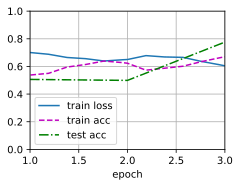

In [28]:
lr, num_epochs = 0.01, 3
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [29]:
def predict_sentiment(net, vocab, sentence):
    sentence = torch.tensor(vocab[sentence.split()], device=try_gpu())
    label = torch.argmax(net(sentence.reshape(1, -1)), dim=1)
    return "positive" if label == 1 else "negative"

In [30]:
predict_sentiment(net, vocab, "this movie is so great")

'positive'

In [31]:
predict_sentiment(net, vocab, "this movie is so bad")

'negative'

# Analysis Extended (Example of Overfitting)
I also tried to analyis by changing the input(train) to 10k and test to 5k and ran it for 10 epochs. You can see the image of the result obtained on figures folder 'bidirectional_rnn.pdf'. When you see he image you find that till around 5 epochs the test accuracy could keep up with the train accuracy but after that the train accuracy started to increase but there didn't change the test accuracy. 

This happened because the model started to overfit on the training data. We should avoid this and try to train it until test accuracy keeps up with train accuracy.
